Produce z500 anomaly (June-Oct) maps for each WT  
 - 1 Compute climatology
 - 2 Compute anomaly of each weather type
 - 3 Plotting 

In [1]:
import sys
import datetime
from datetime import datetime
import calendar
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import glob 
import os.path
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# inorder to import my pathon module, add
# $PYTHONPATH for jupyter for module
sys.path.append("/glade/u/home/mingge/PYTHON")
import coexist_func 
from importlib import reload
reload(coexist_func)
from coexist_func import plot_single
from coexist_func import find_year_top25_wt_smyle
from coexist_func import cal_seasonalmean_wt_smyle
from coexist_func import cal_season_std_smyle
from coexist_func import cal_season_cli_smyle 
from coexist_func import cal_season_ano_smyle
from coexist_func import ax_coastlines_country
from coexist_func import plot_prec_12

In [2]:
level_s = np.array([0, 1, 2.5, 5, 7.5, 10, 15, 20,25, 37.5, 50,
         75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 750])

# declares a recentered projection for Pacific areas
proj = ccrs.PlateCarree(central_longitude=180)

def ax_coastlines_country(ax_s):
    ax_s.coastlines(linewidths=0.5)
    ax_s.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='10m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))

def plot_S2Swt_12(prec, min_v, max_v, n_lev, cmap_s, colorbar_ori, title_s):
    '''
    prec(12,nlat, nlon): 3d variable to plot
    colorbar_ori: colorbar orientation, verticle or horizontal
    title_s: the common title for subplot
    '''
    # relableed WT: 0=Monsoon, 1=Normal, 2=Dry
    wt_s = ['Monsoon', 'Normal', 'Dry']
    
    fig = plt.figure(figsize=(22,12))
    
    cnlevel = np.linspace(min_v, max_v, num=n_lev)
  
    for nr in range(prec.shape[0]):
        for wt in range(prec.shape[1]):
            col = nr*n_wt + wt 
            #print(col, nr, wt) 
            ax_s = plt.subplot(4, 3, col+1, projection=proj)
            ax_coastlines_country(ax_s)
            ax_s.add_feature(cfeature.STATES, linestyle=':')
            #ax_s.add_feature(cartopy.feature.OCEAN,zorder=100, edgecolor='k')
 
            im=prec[nr,wt].plot.contourf(
                levels=cnlevel,
                cmap=cmap_s,
                ax=ax_s,
                center = 0,
                # NOTE: transform use original data center 
                transform=ccrs.PlateCarree(),
                #transform=proj,
                extend='both',
                add_colorbar=False)
        
            # add contour 
            im_c   = prec[nr,wt].plot.contour(ax=ax_s,transform=ccrs.PlateCarree(),levels=np.linspace(min_v, max_v, num=int(n_lev/2) + 1), colors='grey')
        
            # add lat-lon gridlines
            gl = ax_s.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
            gl.xlines = True
            #gl.xlocator = mticker.FixedLocator([120, 140, 160, 180, -160, -140, -120])
            #gl.ylocator = mticker.FixedLocator([0, 20, 40, 60])
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER
            gl.xlabel_style = {'color': 'grey', 'weight': 'bold'}
        
            plt.title(region_s[nr] + ' ' +  wt_s[wt] ,fontweight="bold", size=15)

    # single title for All the Subplot
    fig.suptitle('25 member average ' + title_s, fontweight="bold", fontsize=30)
    
    fig.tight_layout()
    # The position of the bottom edge of the subplots, as a fraction of the figure height.
    #fig.subplots_adjust(bottom=0.15)

    #rect [left, bottom, width, height]
    #cbar_ax = fig.add_axes([0.2, 0.1, 0.7, 0.03])
    #fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
    if colorbar_ori=="vertical":
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.99, 0.1, 0.04, 0.8])
    else:
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.2, 0.001, 0.7, 0.02])
    
    fig.colorbar(im, cax=cbar_ax, orientation=colorbar_ori, extend='both')
        

casper_2020

#### setups

In [4]:
dir_o    = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/'
dir_wt   = dir_o + 'WT_S2S/'
dir_era5 = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/'

year_s = 1970
year_e = 2022
n_year = year_e - year_s + 1

n_wt = 3
MONTHS = [6,7,8,9,10]    # months within the NAM season

lat_s = -20
lat_e = 80
lon_s = 0
lon_e = 360

# there are n_day_s2s = 153 days from June to Oct
dStartDay =datetime(year_s, int(MONTHS[0]), 1,12)
dStopDay = datetime(year_s, int(MONTHS[-1]), 31,12)
rgdTimeDD = pd.date_range(dStartDay, end=dStopDay, freq='d')
n_day_s2s = len(rgdTimeDD)
print(n_day_s2s, 'Days in', MONTHS)

153 Days in [6, 7, 8, 9, 10]


### check on data
 - cfgrib support xr.open_dataset engine="cfgrib"
 - engine="cfgrib"
##### NOTE: 
 - to avoid idx error, use backend_kwargs={'indexpath' :''})
 - in backend_kwargs filter_by_keys set file name and level like:
      "filter_by_keys": {"shortName": "z", "typeOfLevel": "isobaricInhPa"}

In [6]:
flnm = dir_era5 + '200112/e5.oper.an.pl.128_129_z.ll025sc.2001123000_2001123023.nc'
print(flnm)
with  xr.open_dataset(flnm) as ds:
    #print(ds)
    z500 = ds.Z.sel(level=500).sel(latitude=slice(lat_e, lat_s),longitude=slice(lon_s, lon_e)).mean(dim='time')
    latitude = ds['latitude'].sel(latitude=slice(lat_e, lat_s)) 
    longitude = ds['longitude'] 
    n_lat = len(latitude)
    n_lon = len(longitude)
    print(z500.shape)
    #z500.plot()   

/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/200112/e5.oper.an.pl.128_129_z.ll025sc.2001123000_2001123023.nc
(401, 1440)


#### 1) Comupte climatology

In [8]:
year_s = 1970
year_e = 2022
#year_s = 1983
#year_e = 1987
#year_s = year_e
n_year = year_e - year_s + 1

data_4d = np.zeros((n_year, n_day_s2s, n_lat, n_lon))

flnm_cli = dir_o + 'z500_clim_Jun-Oct.nc'
dir_z = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/Z500/'

if os.path.isfile(flnm_cli):
    print(flnm_cli, 'exist')
    with  xr.open_dataset(flnm_cli) as ds:
        z500_cli = ds.z500_clim_Jun_Oct     
        print(ds.dims)
else:
    for year in range(year_s, year_e+1, 1):
        is_first = True
        flnm_z = dir_z + 'z500_' + str(year) + '.nc'
        if os.path.isfile(flnm_z):
            print(flnm_z, 'exist')
            with  xr.open_dataset(flnm_z) as ds_z:
                data_4d[year-year_s] = ds_z.Z
        else:    
            for month in MONTHS:
                yyyymm_s = str(year*100 + month)
                # glob order is arbitrary, sort them 
                for flnm in sorted(glob.glob(dir_era5 + yyyymm_s + "/e5.oper.an.pl.128_129_z.ll025sc.*.nc")):
                    print(flnm)
                    with  xr.open_dataset(flnm) as ds:
                        # select z500hPa, crop to target domain, and daily mean
                        # Follow original ERA from North to South !
                        z500_2d = ds.Z.sel(level=500).sel(latitude=slice(lat_e, lat_s),longitude=slice(lon_s, lon_e)).mean(dim='time') 
    
                        # concatenate daily data 
                        if is_first:
                            z500_3d = z500_2d
                            is_first = False
                        else:
                            z500_3d = xr.concat([z500_3d, z500_2d], dim="time") 
                            
            print(flnm_z)
            z500_3d.to_netcdf(path = flnm_z)  
            data_4d[year-year_s] = z500_3d[:,::-1,:]

    z500_2d = data_4d.mean(axis=(0,1)) 
    print(z500_2d.shape) 
    
    z500_xr = xr.DataArray(z500_2d, 
                    coords={'latitude': ds['latitude'].sel(latitude=slice(lat_e, lat_s)), 
                            'longitude': ds['longitude'].sel(longitude=slice(lon_s, lon_e))},
                    dims = ['latitude', 'longitude'],
                    attrs = {'script':'Ming Ge: z500_S2Swt_ERA5.ipynb',
                            'year':'1970-2022'})
    z500_xr = z500_xr.rename('z500_clim_Jun_Oct') 
    print(flnm_o)
    z500_xr.to_netcdf( path = flnm_o)
 

/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/z500_clim_Jun-Oct.nc exist
Frozen({'latitude': 401, 'longitude': 1440})


#### 2 Calculate anomaly of each weather type

In [9]:
region_s = ['Arizona_East', 'Arizona_West', 'NM_North', 'NM_South'] 
#region_s = ['Arizona_East', 'Arizona_West']
n_region = len(region_s)

flnm_cli = dir_o + 'z500_clim_Jun-Oct.nc'

with  xr.open_dataset(flnm_cli) as ds:
    z500_cli = ds.z500_clim_Jun_Oct      
    print(ds.dims)
    
for region in region_s:
    z500_3d = np.zeros((n_wt, n_lat, n_lon))
    count_1d = np.zeros((n_wt)) 
        
    flnm_o = dir_wt + region + '/z500_ano_' + region + '.nc'
         
    if os.path.isfile(flnm_o):
        print(flnm_o, 'exist')
    else:   
        print('region', region)
        for year in range(year_s, year_e+1, 1):
            flnm_wt = dir_wt + region + '/' + region + '-WTs_' + str(year) +'.cla'               
            wts = pd.read_csv(flnm_wt, delimiter = '\t', header=None,  names=["year", "month", "day", "wt"])
            #print(flnm_wt)
            
            StartDay = datetime(year, MONTHS[0], 1,  0)
            EndDay   = datetime(year, MONTHS[-1], 31,  23)
            TimeDD   = pd.date_range(StartDay, EndDay, freq='d')
                 
            # read ERA5 file
            flnm = dir_z + 'z500_' + str(year) + '.nc'  
            #print(flnm)         
            with xr.open_dataset(flnm) as ds:
                z500_0 = ds.Z
                for nw in wts.wt.unique(): 
                    wts_g = wts.groupby(['wt'])
                    g_ind = wts_g.get_group(nw).index
                    yyyymmdd = wts.year[g_ind]*10000 + wts.month[g_ind]*100 + wts.day[g_ind]                            
                    yyyymmdd_wt = pd.to_datetime((yyyymmdd.values), format='%Y%m%d')
                            
                    # pick WT date
                    iTime_2 = np.isin(TimeDD, yyyymmdd_wt)
                     
                    z500_np = z500_0[iTime_2].values                           
                    z500_3d[nw] = z500_3d[nw] + z500_np.sum(axis=0)   
                    count_1d[nw] = count_1d[nw] + z500_np.shape[0]
                    #print(z500_np.shape[0])
            
        for nw in range(n_wt):                     
            z500_3d[nw] = z500_3d[nw]/count_1d[nw]
            z500_3d[nw] = (z500_3d[nw] - z500_cli)/z500_cli  
            
        z500_xr = xr.DataArray(z500_3d, 
                                coords={'wt':range(n_wt),
                                        'latitude': ds['latitude'].sel(latitude=slice(lat_e, lat_s)), 
                                        'longitude': ds['longitude'].sel(longitude=slice(lon_s, lon_e))},
                                dims=['wt', 'latitude', 'longitude'])
                     
        z500_xr = z500_xr.rename('z500_ano') 
        print(flnm_o)
        z500_xr.to_netcdf(path = flnm_o) 

Frozen({'latitude': 401, 'longitude': 1440})
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/WT_S2S/Arizona_East/z500_ano_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/WT_S2S/Arizona_West/z500_ano_Arizona_West.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/WT_S2S/NM_North/z500_ano_NM_North.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/WT_S2S/NM_South/z500_ano_NM_South.nc exist


#### 3 plotting

In [10]:
z500_4d = np.zeros((n_region, n_wt, n_lat, n_lon))

nr = 0
for region in region_s:
    flnm = dir_wt + region + '/z500_ano_' + region + '.nc'
    print(flnm)
    with  xr.open_dataset(flnm) as ds:
        z500_4d[nr] = ds.z500_ano
    nr = nr + 1
        
z500_xr = xr.DataArray(z500_4d, 
                coords={'latitude': z500_cli.latitude, 'longitude': z500_cli.longitude, 'wt':range(n_wt), 'region':range(n_region)},
                dims=["region", "wt", "latitude", "longitude"])

/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/WT_S2S/Arizona_East/z500_ano_Arizona_East.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/WT_S2S/Arizona_West/z500_ano_Arizona_West.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/WT_S2S/NM_North/z500_ano_NM_North.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/WT_S2S/NM_South/z500_ano_NM_South.nc


In [11]:
print('min:', z500_xr.min(), 'max:', z500_xr.max());

min: <xarray.DataArray ()>
array(-0.02152723) max: <xarray.DataArray ()>
array(0.0174753)


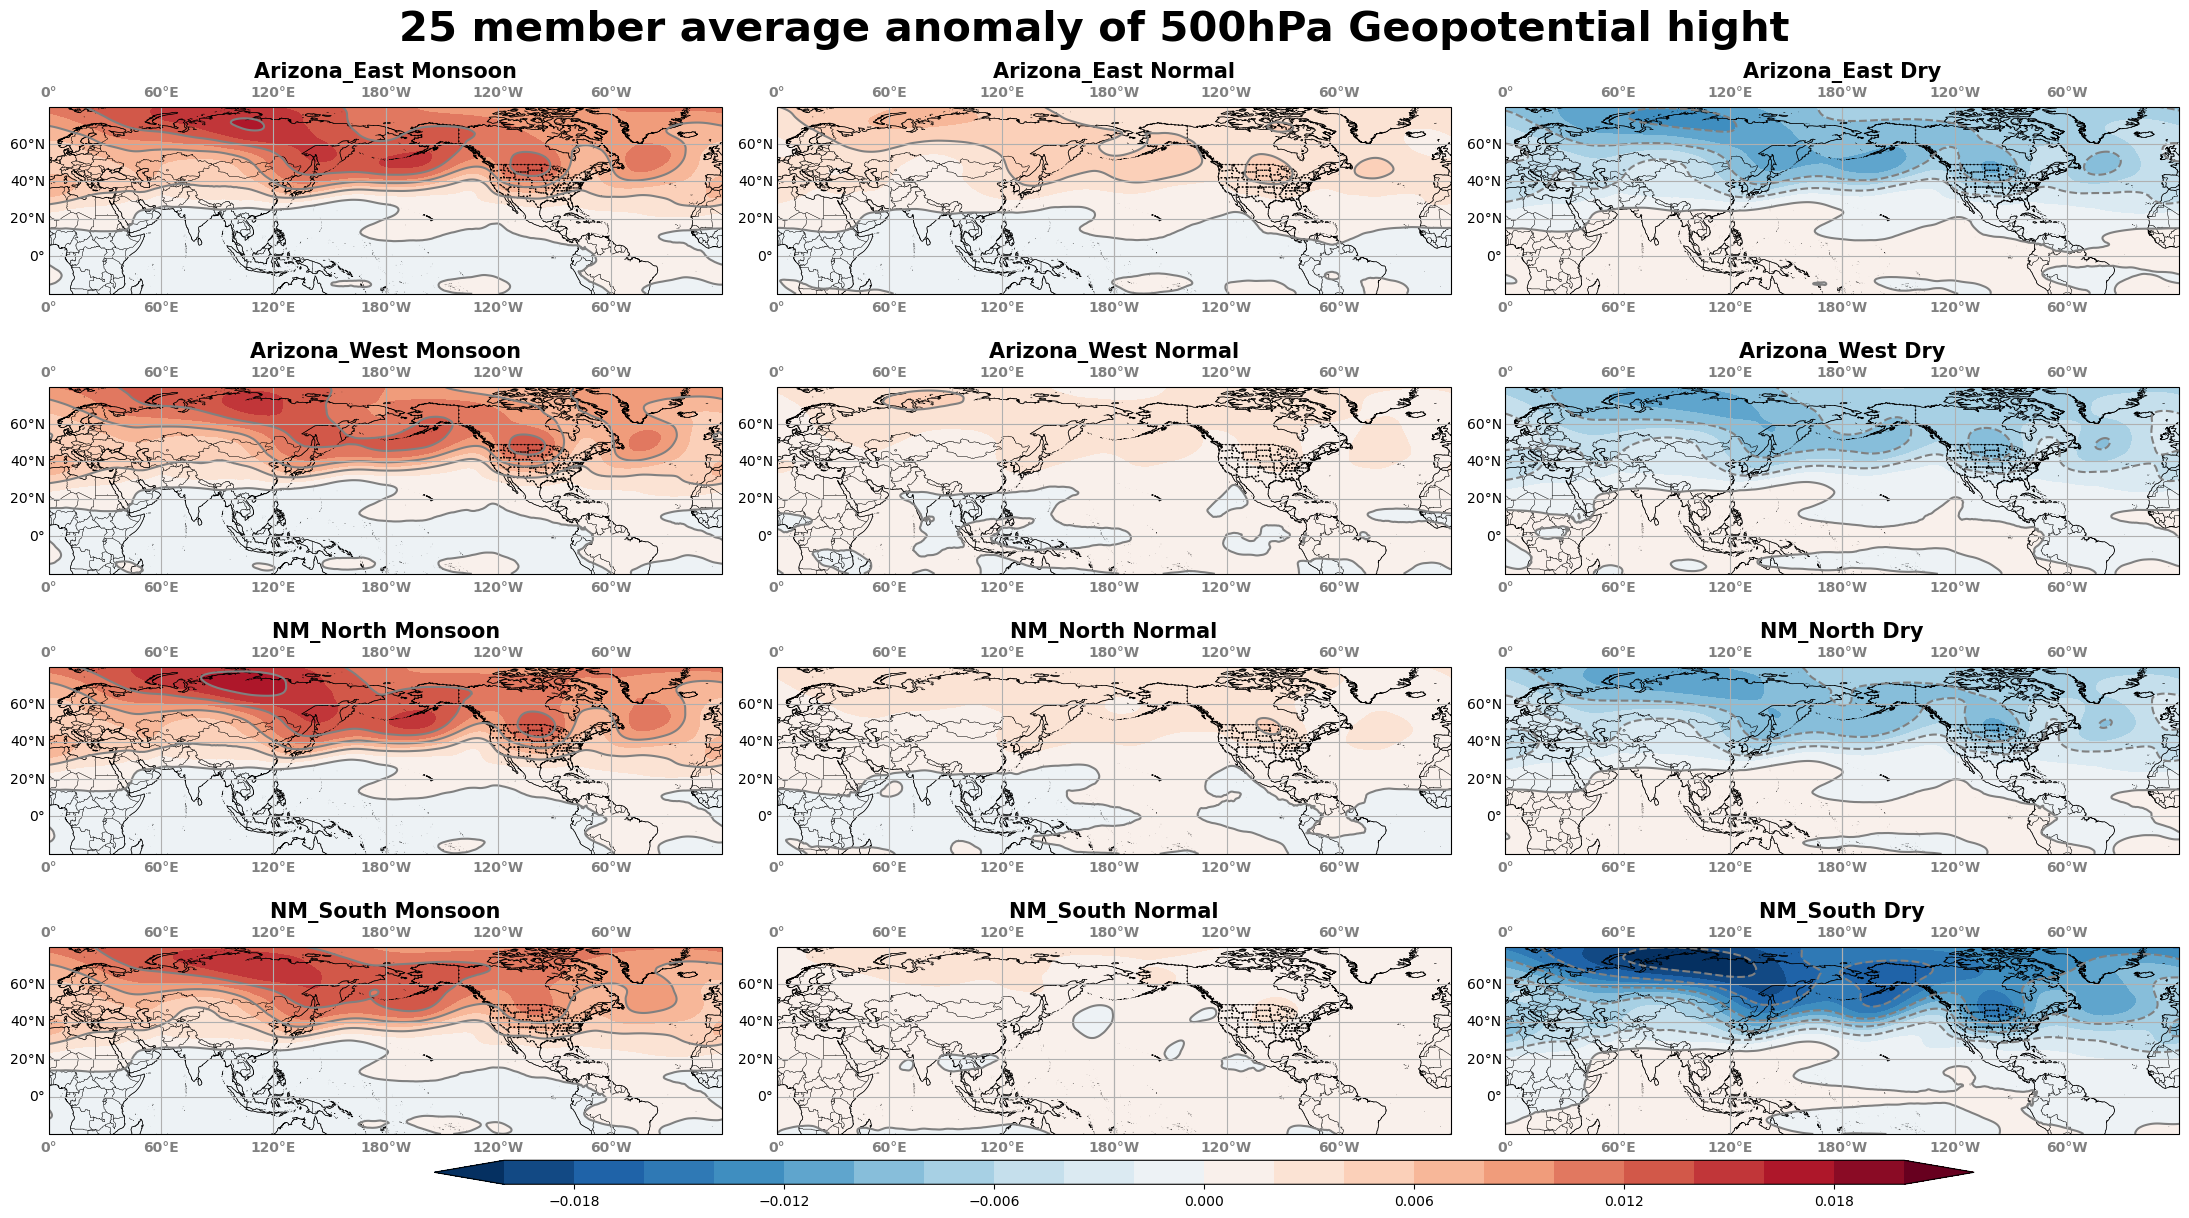

In [12]:
plot_S2Swt_12(z500_xr, -0.02, 0.02, 21, 'RdBu_r', 'horizontal', 'anomaly of 500hPa Geopotential hight')